# Урок 2. Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

__Задание 2.__

__Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог)__

In [1]:
import pandas as pd

Наши новости

In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR" -O articles.csv && rm -rf /tmp/cookies.txt 

--2022-03-07 08:06:11--  https://docs.google.com/uc?export=download&confirm=t&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR
Resolving docs.google.com (docs.google.com)... 74.125.195.101, 74.125.195.100, 74.125.195.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ggsvtfnh57vu5vhp56sm3mrra3m1jkd0/1646640300000/14904333240138417226/*/1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR?e=download [following]
--2022-03-07 08:06:11--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ggsvtfnh57vu5vhp56sm3mrra3m1jkd0/1646640300000/14904333240138417226/*/1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR?e=download
Resolving doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 173.194.202.132, 2607:f8b0:400e:c00::84
Connecting to doc-0s-c0-docs.googleusercontent.com (doc-0s-c

In [3]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [4]:
news.iloc[0]['title']

'Заместитель председателяnправительства РФnСергейnИвановnизбран председателем советаnПБК ЦСКАn. Как сообщаетnпресс-службаnармейцев, такое решение было единогласно принято на первом заседании совета клуба. Основной функцией этого органа будет обсуждение текущего состояния, планирование и утверждение стратегии развития клуба на ближайшую перспективу.nnВ состав совета вошли:nГеоргий Полтавченкоn(полномочный представитель президента в Центральном федеральном округе),nАлексей Седовn(генерал-полковник, начальник службы по защите конституционного строя и борьбе с терроризмомnФСБ РФn),nАлександр Новакn(заместитель министра финансов РФ),nВячеслав Полтавцевn(заместитель генерального директора, руководитель блока по взаимодействию с органами власти, социальной и корпоративной политикиnГМК «Норильский никель»n),nЛеонид Исаковичn(генеральный директор ООО «УК «Спортивные проекты»),nОльга Плешаковаn(генеральный директорn«Трансаэро»n),nАлександр Провоторовn, (генеральный директорnОАО «Ростелеком»n), А

In [5]:
!wget 'https://drive.google.com/uc?export=download&id=1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a' -O users_articles.csv

--2022-03-07 08:06:15--  https://drive.google.com/uc?export=download&id=1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a
Resolving drive.google.com (drive.google.com)... 74.125.195.138, 74.125.195.139, 74.125.195.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fqqnmj21vlssgc7i7ltfqarh8kmob65i/1646640375000/14904333240138417226/*/1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a?e=download [following]
--2022-03-07 08:06:15--  https://doc-04-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fqqnmj21vlssgc7i7ltfqarh8kmob65i/1646640375000/14904333240138417226/*/1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a?e=download
Resolving doc-04-c0-docs.googleusercontent.com (doc-04-c0-docs.googleusercontent.com)... 173.194.202.132, 2607:f8b0:400e:c00::84
Connecting to doc-04-c0-docs.googleusercontent.com (doc-04-c0-doc

Загрузим пользователей и списки последних прочитанных новостей

In [6]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [7]:
!pip install razdel pymorphy2 pyLDAvis

In [8]:
# предобработка текстов
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize  # сегментация русскоязычного текста на токены и предложения https://github.com/natasha/razdel
import pymorphy2  # Морфологический анализатор

In [9]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

151


In [11]:
stopword_ru[:10]

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [12]:
!wget 'https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c' -O stopwords.txt

--2022-03-07 08:06:20--  https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c
Resolving drive.google.com (drive.google.com)... 74.125.197.113, 74.125.197.138, 74.125.197.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.197.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4sp0uaul6es4m3uu7e4o4166d92c9aga/1646640375000/14904333240138417226/*/17wVn5YPpMjHToctGgff_KfSeWcIIlf7c?e=download [following]
--2022-03-07 08:06:20--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4sp0uaul6es4m3uu7e4o4166d92c9aga/1646640375000/14904333240138417226/*/17wVn5YPpMjHToctGgff_KfSeWcIIlf7c?e=download
Resolving doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 173.194.202.132, 2607:f8b0:400e:c00::84
Connecting to doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-doc

In [13]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [14]:
stopword_ru[200:210]

['ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам']

In [15]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [16]:
%%time
from tqdm import tqdm
tqdm.pandas()

# Запускаем очистку текста. Будет долго...
news['title'] = news['title'].progress_apply(lambda x: clean_text(x))

  0%|          | 0/27000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Possible nested set at position 39
  
100%|██████████| 27000/27000 [00:46<00:00, 582.44it/s] 


CPU times: user 35.1 s, sys: 2.17 s, total: 37.2 s
Wall time: 46.4 s


In [17]:
news['title'].iloc[:10]

0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
2    форвард авангарда томаш заборский прокомментир...
3    главный тренер кубани юрий красножан прокоммен...
4    решением попечительского совета владивостокско...
5    ио главного тренера вячеслав буцаев прокоммент...
6    запорожский металлург дома потерпел разгромное...
7    сборная сша одержала победу над австрией со сч...
8    бывший защитник сборной россии дарюс каспарайт...
9    полузащитник цска зоран тошич после победы над...
Name: title, dtype: object

In [18]:
%%time
# Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].progress_apply(lambda x: lemmatization(x))

100%|██████████| 27000/27000 [04:41<00:00, 95.90it/s] 

CPU times: user 4min 37s, sys: 2.03 s, total: 4min 39s
Wall time: 4min 41s


А теперь в 3 строчки обучим нашу модель

In [19]:
# сформируем список наших текстов
texts = list(news['title'].values)

# Создадим корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [20]:
len(common_dictionary)

135645

In [21]:
common_dictionary[4]

'банк'

In [22]:
# common_dictionary.id2token

In [23]:
common_dictionary.doc2bow(['коллега', 'пошел', 'пить', 'чай'], allow_update=True)

[(993, 1), (6129, 1), (12270, 1), (135645, 1)]

Запускаем обучение

In [24]:
N_topic = 20

In [25]:
%%time
from gensim.models import LdaModel

# Обучаем модель на корпусе
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

CPU times: user 46.7 s, sys: 21.8 s, total: 1min 8s
Wall time: 43.9 s


In [26]:
from gensim.test.utils import datapath

# Сохраняем модель на диск
temp_file = datapath("model.lda")
lda.save(temp_file)

In [27]:
# Загружаем обученную модель с диска
lda = LdaModel.load(temp_file)

In [28]:
# Создаем новый корпус документов, которые раньше не видели
other_texts = list(news['title'].iloc[:3])
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(2, 0.5492673), (9, 0.13228194), (14, 0.29720077)]

In [29]:
x = lda.show_topics(num_topics=N_topic, num_words=7, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Печатаем только слова
for topic, words in topics_words:
    print(f"topic_{topic}: " + " ".join(words))

topic_0: производитель квартира сон премия высота max лауреат
topic_1: луна клетка русский баррель улица церковь американский
topic_2: двигатель океан научный скорость мкс топливо обращение
topic_3: газ обнаружить европа товар организм всё лечение
topic_4: земля журнал взрыв рак всё ru опубликовать
topic_5: статья продукт руб продукция тыс размер автор
topic_6: банк рубль уголовный статья лицо задержать орган
topic_7: эксперимент налог млн выяснить британский медицина выставка
topic_8: корабль самолёт российский армия миссия экипаж полёт
topic_9: научный россия совет государство ru решение газета
topic_10: исследование гражданин область рубль система россия рынок
topic_11: фонд китайский китай остров px обнаружить планета
topic_12: день советский фестиваль заболевание завод ссср красный
topic_13: животное турист учёный доклад активность новый инвестиция
topic_14: украина украинский поверхность смерть киев нафтогаз бизнесмен
topic_15: американский снижение цена запуск доллар сша спутник

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [30]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [31]:
get_lda_vector(lda, news['title'].iloc[0])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.99166667,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [32]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

CPU times: user 37.5 s, sys: 20.3 s, total: 57.8 s
Wall time: 35 s


In [33]:
topic_matrix.head()

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
1,4896,0.0,0.0,0.000000,0.00000,0.641131,0.0,0.05591,0.0,0.0,...,0.0,0.0,0.122498,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
2,4897,0.0,0.0,0.549250,0.00000,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.2972,0.0,0.0,0.0,0.0,0.0
3,4898,0.0,0.0,0.422087,0.18965,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
4,4899,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0


### Следующий шаг - векторные представления пользователей

In [34]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [35]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

In [36]:
doc_dict[293672]

array([0.        , 0.        , 0.        , 0.02390751, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.35650429, 0.        , 0.08684205, 0.15726003, 0.        ,
       0.        , 0.1788578 , 0.18262826, 0.        , 0.        ])

In [37]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.mean(user_vector, 0)  # среднее
    return user_vector

In [38]:
user_articles_list = users['articles'].iloc[33]

get_user_embedding(user_articles_list, doc_dict)

array([0.        , 0.10698716, 0.00492422, 0.01089474, 0.02001347,
       0.        , 0.12252441, 0.        , 0.04281589, 0.14134904,
       0.03685316, 0.        , 0.00978115, 0.01363501, 0.        ,
       0.1271121 , 0.        , 0.14782003, 0.04369304, 0.16251466])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [39]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

CPU times: user 390 ms, sys: 5.97 ms, total: 396 ms
Wall time: 395 ms


In [40]:
user_embeddings.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.019858,0.077254,0.008241,0.003985,0.015745,0.066990,0.151139,0.011914,0.030331,...,0.117986,0.000000,0.028434,0.088758,0.084033,0.029056,0.056307,0.055693,0.105762,0.026593
1,u108690,0.004618,0.021478,0.010198,0.023158,0.052440,0.005487,0.113873,0.006001,0.024114,...,0.047647,0.009719,0.012902,0.029159,0.087079,0.070830,0.028804,0.152980,0.101064,0.060044
2,u108339,0.000000,0.126604,0.014309,0.013529,0.035327,0.007227,0.156765,0.002937,0.045733,...,0.078000,0.006107,0.007647,0.018595,0.002797,0.047954,0.040755,0.112416,0.160239,0.043035
3,u101138,0.123197,0.000000,0.024519,0.123476,0.090408,0.004409,0.000000,0.000000,0.004184,...,0.046069,0.034543,0.166385,0.036715,0.037100,0.003025,0.060870,0.055996,0.007634,0.036983
4,u108248,0.002579,0.083332,0.060654,0.107305,0.058913,0.057648,0.051861,0.037189,0.043247,...,0.071620,0.005816,0.016320,0.041566,0.017653,0.000000,0.029903,0.055281,0.051764,0.027527


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [41]:
!wget 'https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK' -O users_churn.csv

--2022-03-07 08:13:25--  https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK
Resolving drive.google.com (drive.google.com)... 74.125.195.101, 74.125.195.139, 74.125.195.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lo3l9khodi8pedmql0q6qtehldp9tlb7/1646640750000/14904333240138417226/*/1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK?e=download [following]
--2022-03-07 08:13:25--  https://doc-0k-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lo3l9khodi8pedmql0q6qtehldp9tlb7/1646640750000/14904333240138417226/*/1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK?e=download
Resolving doc-0k-c0-docs.googleusercontent.com (doc-0k-c0-docs.googleusercontent.com)... 173.194.202.132, 2607:f8b0:400e:c00::84
Connecting to doc-0k-c0-docs.googleusercontent.com (doc-0k-c0-doc

In [42]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [43]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.019858,0.077254,0.008241,0.003985,0.015745,0.066990,0.151139,0.011914,0.030331,...,0.000000,0.028434,0.088758,0.084033,0.029056,0.056307,0.055693,0.105762,0.026593,0
1,u108690,0.004618,0.021478,0.010198,0.023158,0.052440,0.005487,0.113873,0.006001,0.024114,...,0.009719,0.012902,0.029159,0.087079,0.070830,0.028804,0.152980,0.101064,0.060044,1
2,u108339,0.000000,0.126604,0.014309,0.013529,0.035327,0.007227,0.156765,0.002937,0.045733,...,0.006107,0.007647,0.018595,0.002797,0.047954,0.040755,0.112416,0.160239,0.043035,1


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [45]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [46]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [47]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.07127801, 0.02375908, 0.61889093, 0.16285933, 0.23244876,
       0.02444209, 0.12888475, 0.12492536, 0.06930875, 0.13803085])

### Рассчитаем Precision, Recall, F_score

In [48]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, confusion_matrix)

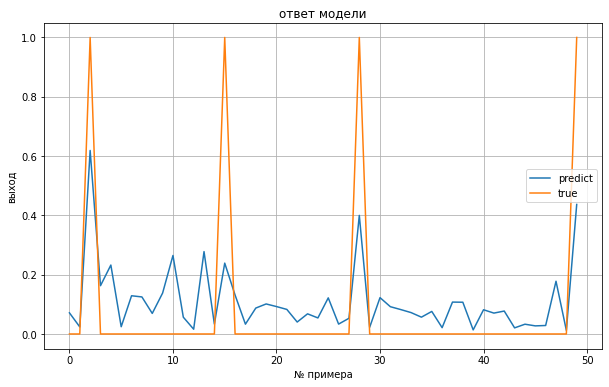

In [49]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [50]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.23506973417259405, F-Score=0.664, Precision=0.574, Recall=0.788


In [51]:
precision_1 = precision[ix]
recall_1 = recall[ix]
thresholds_1 = thresholds[ix]
fscore_1 = fscore[ix]

In [52]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1612  143]
 [  53  192]]


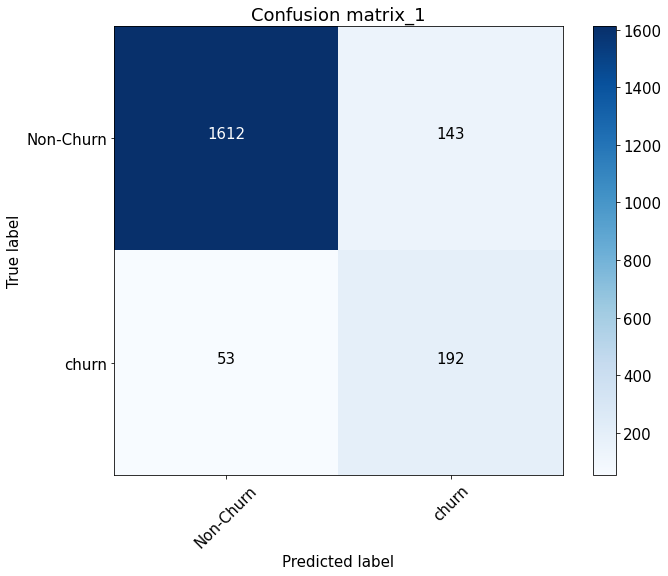

In [53]:
import itertools
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix_1')
plt.savefig("conf_matrix_1.png")
plt.show()

In [54]:
roc_1 = roc_auc_score(y_test, preds)
roc_1

0.9443479272050701

__Модифицируем код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана:__

In [55]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.median(user_vector, 0)  # медиана
    return user_vector

In [56]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

CPU times: user 701 ms, sys: 10 ms, total: 711 ms
Wall time: 714 ms


In [57]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.0,0.015484,0.000000,0.000000,0.000000,0.014457,0.125699,0.0,0.000000,...,0.0,0.019094,0.016972,0.000000,0.017497,0.038931,0.031964,0.026367,0.00000,0
1,u108690,0.0,0.012237,0.008269,0.014375,0.019781,0.000000,0.059501,0.0,0.025371,...,0.0,0.000000,0.000000,0.040612,0.018158,0.005259,0.165418,0.106087,0.02243,1
2,u108339,0.0,0.076373,0.007371,0.000000,0.026123,0.000000,0.136181,0.0,0.040593,...,0.0,0.000000,0.011370,0.000000,0.008633,0.037946,0.097358,0.145310,0.01225,1


In [58]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [59]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [60]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.05309446, 0.01802589, 0.5561156 , 0.33941012, 0.13541861,
       0.04083789, 0.11154093, 0.05274065, 0.07246919, 0.26693131])

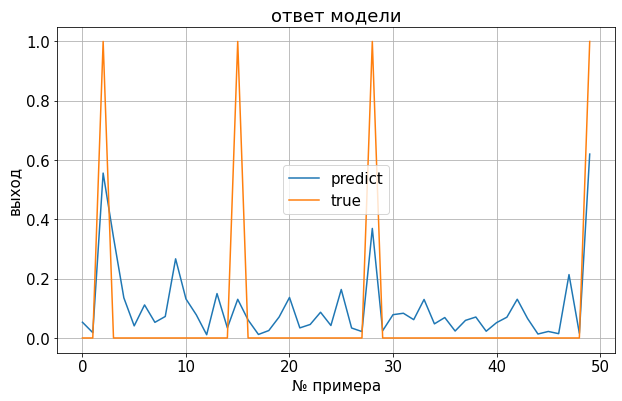

In [61]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [62]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.2687610756090273, F-Score=0.738, Precision=0.694, Recall=0.788


In [63]:
precision_2 = precision[ix]
recall_2 = recall[ix]
thresholds_2 = thresholds[ix]
fscore_2 = fscore[ix]

Confusion matrix, without normalization
[[1670   85]
 [  53  192]]


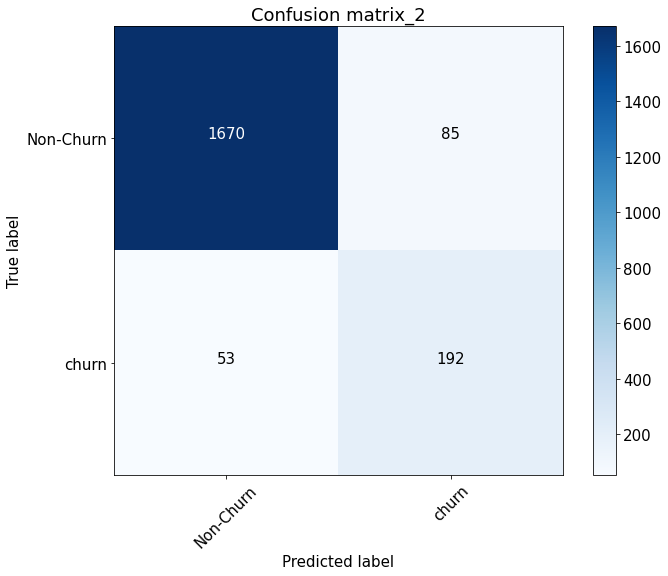

In [64]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix_2')
plt.savefig("conf_matrix_2.png")
plt.show()

In [65]:
roc_2 = roc_auc_score(y_test, preds)
roc_2

0.9601604744461887

__Задание 3.__

__Повторить п.2, но используя уже не медиану, а max__

__Модифицируем код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а max:__

In [66]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.max(user_vector, 0)  # max
    return user_vector

In [67]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

CPU times: user 310 ms, sys: 2.83 ms, total: 313 ms
Wall time: 315 ms


In [68]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.119150,0.271580,0.049444,0.023908,0.094467,0.340071,0.341926,0.055582,0.154704,...,0.000000,0.086842,0.341344,0.488082,0.085818,0.178858,0.182628,0.371053,0.145261,0
1,u108690,0.015266,0.071785,0.027909,0.055679,0.157567,0.032924,0.347776,0.018645,0.048340,...,0.058312,0.053434,0.174952,0.259919,0.333999,0.144148,0.263478,0.249941,0.240570,1
2,u108339,0.000000,0.436239,0.039156,0.066820,0.104268,0.029430,0.414277,0.017620,0.089582,...,0.021453,0.045880,0.066304,0.016782,0.208392,0.122388,0.281389,0.354838,0.173830,1


In [69]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [70]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [71]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.08410351, 0.00292317, 0.92226453, 0.04056772, 0.20795855,
       0.00232424, 0.13064571, 0.66725046, 0.02049083, 0.19755043])

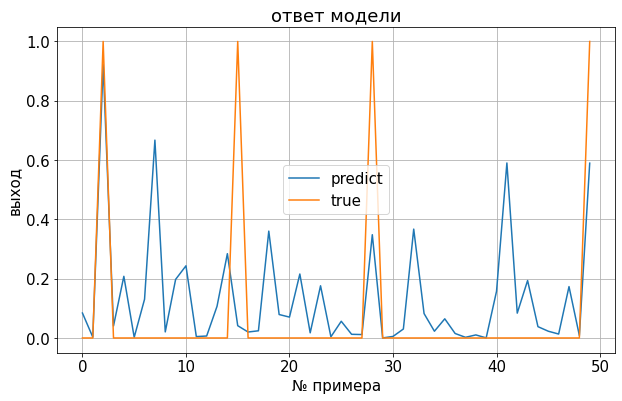

In [72]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [73]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.2811397507566911, F-Score=0.691, Precision=0.617, Recall=0.784


In [74]:
precision_3 = precision[ix]
recall_3 = recall[ix]
thresholds_3 = thresholds[ix]
fscore_3 = fscore[ix]

Confusion matrix, without normalization
[[1636  119]
 [  54  191]]


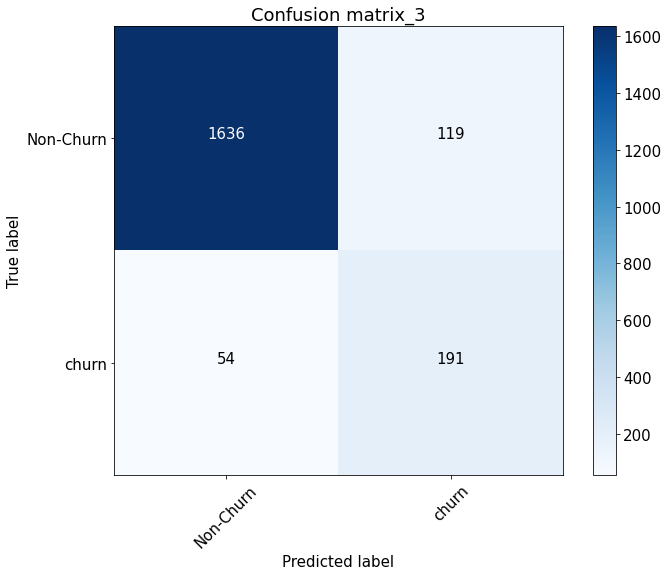

In [75]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix_3')
plt.savefig("conf_matrix_3.png")
plt.show()

In [76]:
roc_3 = roc_auc_score(y_test, preds)
roc_3

0.9472922844351416

__Задание 5.__

__Сформировать на выходе единую таблицу, сравнивающую качество 2/3 разных метода получения эмбедингов пользователей: median, max, idf_mean по метрикам roc_auc, precision, recall, f_score__

In [77]:
roc = [roc_1, roc_2, roc_3]
prec = [precision_1, precision_2, precision_3]
rec = [recall_1, recall_2, recall_3]
f_s = [fscore_1, fscore_2, fscore_3]
score_list = [roc, prec, rec, f_s]

final_tab = pd.DataFrame(score_list, index=['roc_auc', 'precision', 'recall', 'f_score'], columns=['mean', 'median', 'max'])
final_tab

,mean,median,max
roc_auc,0.944348,0.960160,0.947292
precision,0.574405,0.694245,0.617363
recall,0.787755,0.787755,0.783673
f_score,0.664372,0.738050,0.690647


__Задание 6.__

__Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных:__

Самым эфективным оказался способ с использованием медианы. Видимо, медиана дает наиболее точное отображение характера распределения числовых данных в массиве user_vector.